## Load data

In [1]:
import pandas as pd

df = pd.read_csv('patient_data.csv')

In [2]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title='Profiling Report', minimal=True)
# profile.to_file("data_profile.html")

## Prepare data

In [3]:
from preprocessing import preprocess_data

df = preprocess_data(df)

In [4]:
df.head()

,female,age,hosplos,iculos,apache2,ADMITLOCATIONTXT,PrimaryDiagnosis,INITIALADMIT,Overflow,Mechanical.Ventilation,vasoactive,Oncatheter,OnInsulin,readmit72
0,0.0,0.442105,0.035615,0.077110,0.505952,0.285714,0.867508,1.0,0.0,1.0,1.0,0.0,1.0,False
1,1.0,0.642105,0.034454,0.065550,0.321429,0.214286,0.451104,1.0,1.0,1.0,1.0,0.0,1.0,True
2,1.0,0.642105,0.034454,0.024676,0.410714,0.928571,0.927445,0.0,1.0,1.0,1.0,1.0,1.0,True
3,1.0,0.642105,0.034454,0.036309,0.392857,0.000000,0.801262,0.0,0.0,1.0,0.0,1.0,0.0,False
4,0.0,0.715789,0.016288,0.015912,0.303571,0.000000,0.854890,1.0,1.0,1.0,0.0,1.0,0.0,False


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df.drop(columns='readmit72')
y = df['readmit72']

# Identify indices of all positive and negative samples
positive_indices = np.where(y.values == 1)[0]
negative_indices = np.where(y.values == 0)[0]

# Sample negative indices to match the number of positive samples
sampled_negative_indices = np.random.choice(negative_indices, size=len(positive_indices), replace=True)

# Combine and shuffle indices
sampled_indices = np.concatenate([positive_indices, sampled_negative_indices])
np.random.shuffle(sampled_indices)

# Select sampled data from the original dataset
X = X.values[sampled_indices]
y = y.values[sampled_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from torch.utils.data import DataLoader, TensorDataset
import torch

# Convert DataFrame to PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor.view(-1, 1))
test_dataset = TensorDataset(X_test_tensor, y_test_tensor.view(-1, 1))

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=19, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=6, shuffle=False, num_workers=19, persistent_workers=True)

## Cross correlation analysis

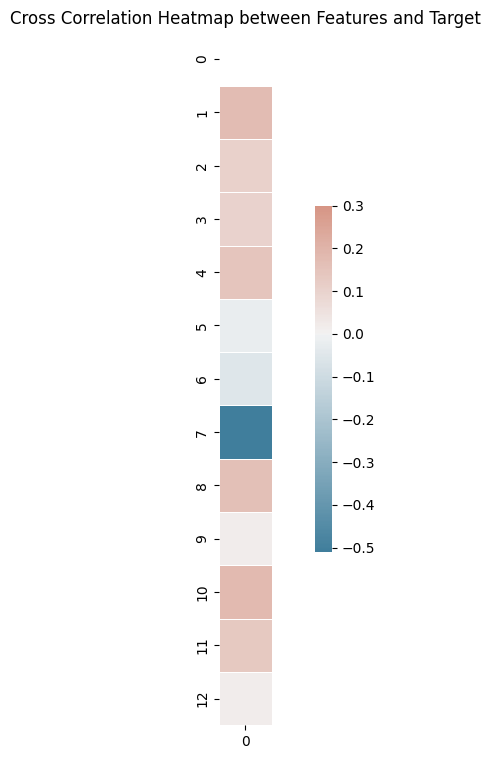

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = np.corrcoef(X.T, y)[0:X.shape[1], X.shape[1]:]

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Cross Correlation Heatmap between Features and Target')
plt.show()

## Random forest for comparison

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Testing Accuracy: 0.7802197802197802


## MLP

In [9]:
from MLP import MLP
import pytorch_lightning as pl

model = MLP()
trainer = pl.Trainer(max_epochs=35)
trainer.fit(model, train_dataloader)
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 1.1 K 
--------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7362637519836426     │
│         test_loss         │    0.4931391477584839     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4931391477584839, 'test_accuracy': 0.7362637519836426}]

## KAN

In [10]:
from KAN import KAN
import pytorch_lightning as pl

model = KAN()
trainer = pl.Trainer(max_epochs=35)
trainer.fit(model, train_dataloader)
trainer.test(model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type     | Params
------------------------------------------
0 | kan1         | KANLayer | 221   
  | other params | n/a      | 2     
------------------------------------------
132       Trainable params
91        Non-trainable params
223       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7857142857142857     │
│         test_loss         │    0.5197722872534951     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5197722872534951, 'test_accuracy': 0.7857142857142857}]

In [ ]:
# from kan import KAN

# model = KAN(width=[13, 1], grid=20, k=3)

# dataset = {
#     'train_input': X_train_tensor,
#     'train_label': y_train_tensor.view(-1, 1),
#     'test_input': X_test_tensor,
#     'test_label': y_test_tensor.view(-1, 1)
# }

# def train_precision():
#     predictions = torch.round(model(dataset['train_input'])[:,0])
#     correct_predictions = predictions == dataset['train_label'][:,0]
#     precision = torch.sum(correct_predictions.float()) / (torch.sum(predictions) + 1e-8)
#     return precision

# def test_precision():
#     predictions = torch.round(model(dataset['test_input'])[:,0])
#     correct_predictions = predictions == dataset['test_label'][:,0]
#     precision = torch.sum(correct_predictions.float()) / (torch.sum(predictions) + 1e-8)
#     return precision

# results = model.train(dataset, opt="ADAM", steps=30, metrics=(train_precision, test_precision));
# results['train_precision'][-1], results['test_precision'][-1]

In [ ]:
# model.plot(beta=100, scale=1.05)

In [ ]:
# lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
# model.auto_symbolic(lib=lib)

In [ ]:
# formula = model.symbolic_formula()[0][0]
# formula

In [ ]:
# import numpy as np

# # Test formula accuracy
# def acc(formula, X, y):
#     batch = X.shape[0]
#     correct = 0
#     for i in range(batch):
#         logit = np.round(np.array(formula.subs('x_1', X[i,0])
#                          .subs('x_2', X[i,1])
#                          .subs('x_3', X[i,2])
#                          .subs('x_4', X[i,3])
#                          .subs('x_5', X[i,4])
#                          .subs('x_6', X[i,5])
#                          .subs('x_7', X[i,6])
#                          .subs('x_8', X[i,7])
#                          .subs('x_9', X[i,8])
#                          .subs('x_10', X[i,9])).astype(np.float64))
#         correct += logit == y[i]
#     return correct/batch

# print('train acc of the formula:', acc(formula, dataset['train_input'], dataset['train_label']))
# print('test acc of the formula:', acc(formula, dataset['test_input'], dataset['test_label']))